In [ ]:
import torch
import matplotlib.pyplot as plt
from fastcore.basics import patch
import uuid
import pdb
import torch

device='cpu'

class Genome:
    def __init__(self, n_chr, n_loci):
        self.ploidy = 2
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.shape = (self.ploidy, self.n_chr, self.n_loci)
        
class Population:
    def __init__(self, genome, haplotypes, device=device):
        self.genome = genome
        self.device = device
        self.phenotypes = None
        self.haplotypes = haplotypes
        self.dosages = haplotypes.sum(dim=1).float()
                
class Trait:
    def __init__(self, genome, founder_population, target_mean, target_variance, device=device):
        self.target_mean = target_mean
        self.target_variance = target_variance
        self.device = device
        random_effects = torch.randn(genome.n_chr, genome.n_loci, device=self.device)
        random_effects -= random_effects.mean()
        founder_scores = torch.einsum('kl,hkl->h', random_effects, founder_population.dosages)
        founder_mean, founder_var = founder_scores.mean(), founder_scores.var()
        scaling_factors = torch.sqrt(self.target_variance / founder_var)
        self.scaling_factors = scaling_factors
        random_effects *= scaling_factors
        self.effects = random_effects
        self.intercept = founder_mean - target_mean

        
def calculate_breeding_value(population_dosages, trait_effects, device = device):
    return torch.einsum('hjk,jk->h', population_dosages,trait_effects)

def truncation_selection(population, trait, top_percent):
    return torch.topk(population.phenotypes, top_percent).indices

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape    
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
    #crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * (1 - crossovers) + paternal * crossovers
    return progeny


def phenotype(population, trait, h2):
    breeding_values = calculate_breeding_value(population.dosages, trait.effects) 
    if breeding_values.var() == 0:
        print('phenotype: no var')
        environmental_variance = 0  
    else:
        environmental_variance = (1 - h2) / h2 * breeding_values.var() 
    environmental_noise = torch.randn(breeding_values.shape, device=device) * torch.sqrt(environmental_variance.clone().detach())
    population.phenotypes = breeding_values + environmental_noise

#     def _create_random_haplotypes(self,num_individuals):
#         return torch.randint(0, 2, (num_individuals, *self.g.shape), device=self.device)
def create_random_pop(G, pop_size):
    return torch.randint(0, 2, (pop_size, *G.shape), device= device)

def update_pop(population, haplotype_pop_tensor):
    population.haplotypes = haplotype_pop_tensor
    population.dosages = haplotype_pop_tensor.sum(dim=1).float()
    return population

# meiosis
def recombine(parent_haplo_tensor, recombination_rate=0.1):
    num_individuals, ploidy, num_chromosomes, num_loci = parent_haplo_tensor.shape
    # Generate crossover masks
    maternal, paternal = parent_haplo_tensor[:,0,:,:],parent_haplo_tensor[:,1,:,:],
    crossovers = torch.bernoulli(torch.full((num_individuals, num_chromosomes, num_loci), recombination_rate, device=device))
#     crossovers = torch.rand((num_individuals, num_chromosomes, num_loci), device=device) < recombination_rate
    progeny = maternal * torch.logical_not(crossovers) + paternal * crossovers
    return progeny

def breed(mother_tensor, father_tensor, recombination_rate=0.1):
    eggs = recombine(mother_tensor,recombination_rate)
    pollens = recombine(father_tensor,recombination_rate)
    return torch.stack((eggs,pollens), dim=1)

def create_pop(G, haplotypes):
    return Population(G, haplotypes=haplotypes)

def bv(P,T):
    P.breeding_values = calculate_breeding_value(P.dosages,T.effects)
    
def create_progeny(mother_gametes, father_gametes,reps = 1):
    progeny = []
    for _ in range(reps):
        # Randomly shuffle the gametes from each parent 
        shuffled_mother_indices = torch.randperm(mother_gametes.shape[0])
        shuffled_father_indices = torch.randperm(father_gametes.shape[0])

        # Select the shuffled gametes
        mother_gametes = mother_gametes[shuffled_mother_indices]
        father_gametes = father_gametes[shuffled_father_indices]

        # Stack the gametes to create progeny haplotypes
        progeny_haplotypes = torch.stack((mother_gametes, father_gametes),dim=1)
        progeny.append(progeny_haplotypes)
    return torch.vstack(progeny)

G = Genome(1,1000)
P = create_pop(G, create_random_pop(G, 200))
# update_pop(P, create_random_pop(G,300))
T = Trait(G,P,0,1)
pops = []

(array([ 7., 13., 22., 41., 31., 28., 21., 21., 12.,  4.]),
 array([-1.9605155 , -1.32632852, -0.69214141, -0.05795441,  0.57623261,
         1.21041965,  1.84460664,  2.47879362,  3.11298084,  3.74716783,
         4.38135481]),
 <BarContainer object of 10 artists>)

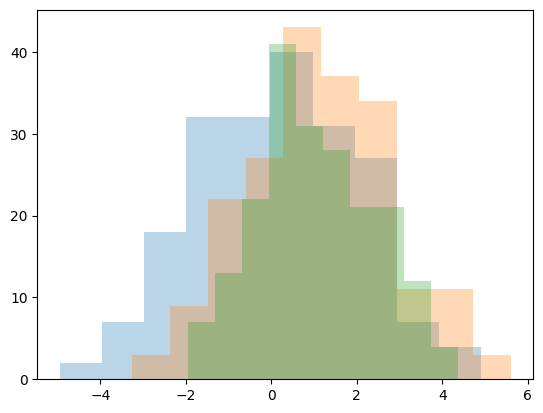

In [ ]:
pop_size=200
h2 = .25


####
G = Genome(1,1000)
P = create_pop(G, create_random_pop(G, pop_size))
# update_pop(P, create_random_pop(G,300))
T = Trait(G,P,0,1)
pops = []

bv(P,T) #calculate breeding values
phenotype(P,T,.3) # calculate phenotypes with h2 = .3 for noise
pops.append(P) # store the founder pop
selected = P.haplotypes[torch.topk(P.phenotypes,pop_size//10).indices] # select top 20 individuals based on phenotype
m = recombine(selected) # mother gametes
f = recombine(selected) # father gametes

#f1
f1 = create_progeny(m, f, reps= 10) # create 10 offspring for each selected paren
f1 = Population(G, f1)
bv(f1, T)
phenotype(f1,T,h2=h2)


#f2
f2 = f1.haplotypes[torch.topk(f1.phenotypes,pop_size//10).indices] # select top 20 individuals based on phenotype
m = recombine(selected) # mother gametes
f = recombine(selected) # father gametes
f2 = create_progeny(m, f, reps= 10) # create 10 offspring for each selected paren
f2 = Population(G, f2)
bv(f2,T)
phenotype(f2, T, h2)


plt.hist(P.phenotypes,alpha=.3)
plt.hist(f1.phenotypes,alpha=.3)
plt.hist(f2.phenotypes,alpha=.3)